# Analysis of the gills
- Oleksiy and Flu scanned them
- Dea delineated them
- David does the analysis

In [1]:
import platform
import os
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_style('dark')
import numpy
import scipy.misc
from matplotlib_scalebar.scalebar import ScaleBar
import skimage.filters
import skimage.morphology
import numpy.ma

In [2]:
# My figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (32, 18)  # Size up figures a bit
plt.rcParams["savefig.transparent"] = False

In [3]:
# Setup scale bar
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [4]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [5]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [6]:
# Load all the data from here
if 'debian' in platform.dist():
    StartDir = '/media/habi/Blue Seagate/'
else:
    StartDir = 'SomeDriveP:/'
RootFolder = os.path.join(StartDir, 'Zebra-Fish_Matthias')

In [7]:
# Make directory for output
OutPutDir = os.path.join(RootFolder, 'Output', get_git_hash())
print(OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

/media/habi/Blue Seagate/Zebra-Fish_Matthias/Output/ab60e1b


In [8]:
# Display all plots identically
lines = 5
# And then do something like
# plt.subplot(lines, numpy.ceil(len(ROIFolders) / float(lines)), c + 1)

Let's get going, now that we set up everything...

In [9]:
print('We are loading all the data from %s' % RootFolder)

We are loading all the data from /media/habi/Blue Seagate/Zebra-Fish_Matthias


In [10]:
# Get a list of all the samples we scanned
SampleNames = sorted(next(os.walk(RootFolder))[1])

In [11]:
# Remove folders we don't want
SampleNames.remove('Original SEM Bilder')
SampleNames.remove('Output')
SampleNames.remove('tresholding_estimation')

In [12]:
# Generate a list of all the stuff we need
Folders = [os.path.join(RootFolder, s) for s in SampleNames]
LogFiles = [sorted(glob.glob(os.path.join(f, 'proj', '*.log')))[0] for f in Folders]
RecFolders = [os.path.join(RootFolder, f, 'rec') for f in Folders]
VOIFolders = [os.path.join(RootFolder, f, 'VOI') for f in Folders]
OverviewNames = [glob.glob(os.path.join(r, '*spr.bmp')) for r in RecFolders]
ReconstructionNames = [sorted(glob.glob(os.path.join(r, '*.png'))) for r in RecFolders]
VOINames = [sorted(glob.glob(os.path.join(r, '*.png'))) for r in VOIFolders]

In [13]:
# Make an 'experiment' column, which we use for the box plots below
def whichexperiment(i):
    '''Categorize  into 'Swimmer' or 'Control' '''
    if 'immer' in i:
        return 'Swimmer'
    if 'ontrol' in i:
        return 'Control'

In [14]:
Experiment = [whichexperiment(name) for name in Folders]

In [15]:
# Color plot based on label (mrt, ctrl or bb)
def color_based_on_experiment(i):
    '''Colorize into 'Swimmer' or 'Control' '''
    if 'immer' in i:
        return seaborn.color_palette()[0]
    if 'ontrol' in i:
        return seaborn.color_palette()[1]

In [16]:
experimentcolor = [color_based_on_experiment(name) for name in Folders]

In [17]:
# Get Pixel sizes of the scans
PixelSize = [get_pixelsize(logfile) for logfile in LogFiles]

In [18]:
# Load Overviews
Overviews = [scipy.misc.imread(o[0], flatten=True) for o in OverviewNames]

/home/habi/P/Dev/matplotlib-scalebar/matplotlib_scalebar/scalebar.py:449: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(loc):
/home/habi/P/Dev/matplotlib-scalebar/matplotlib_scalebar/scalebar.py:290: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(location):


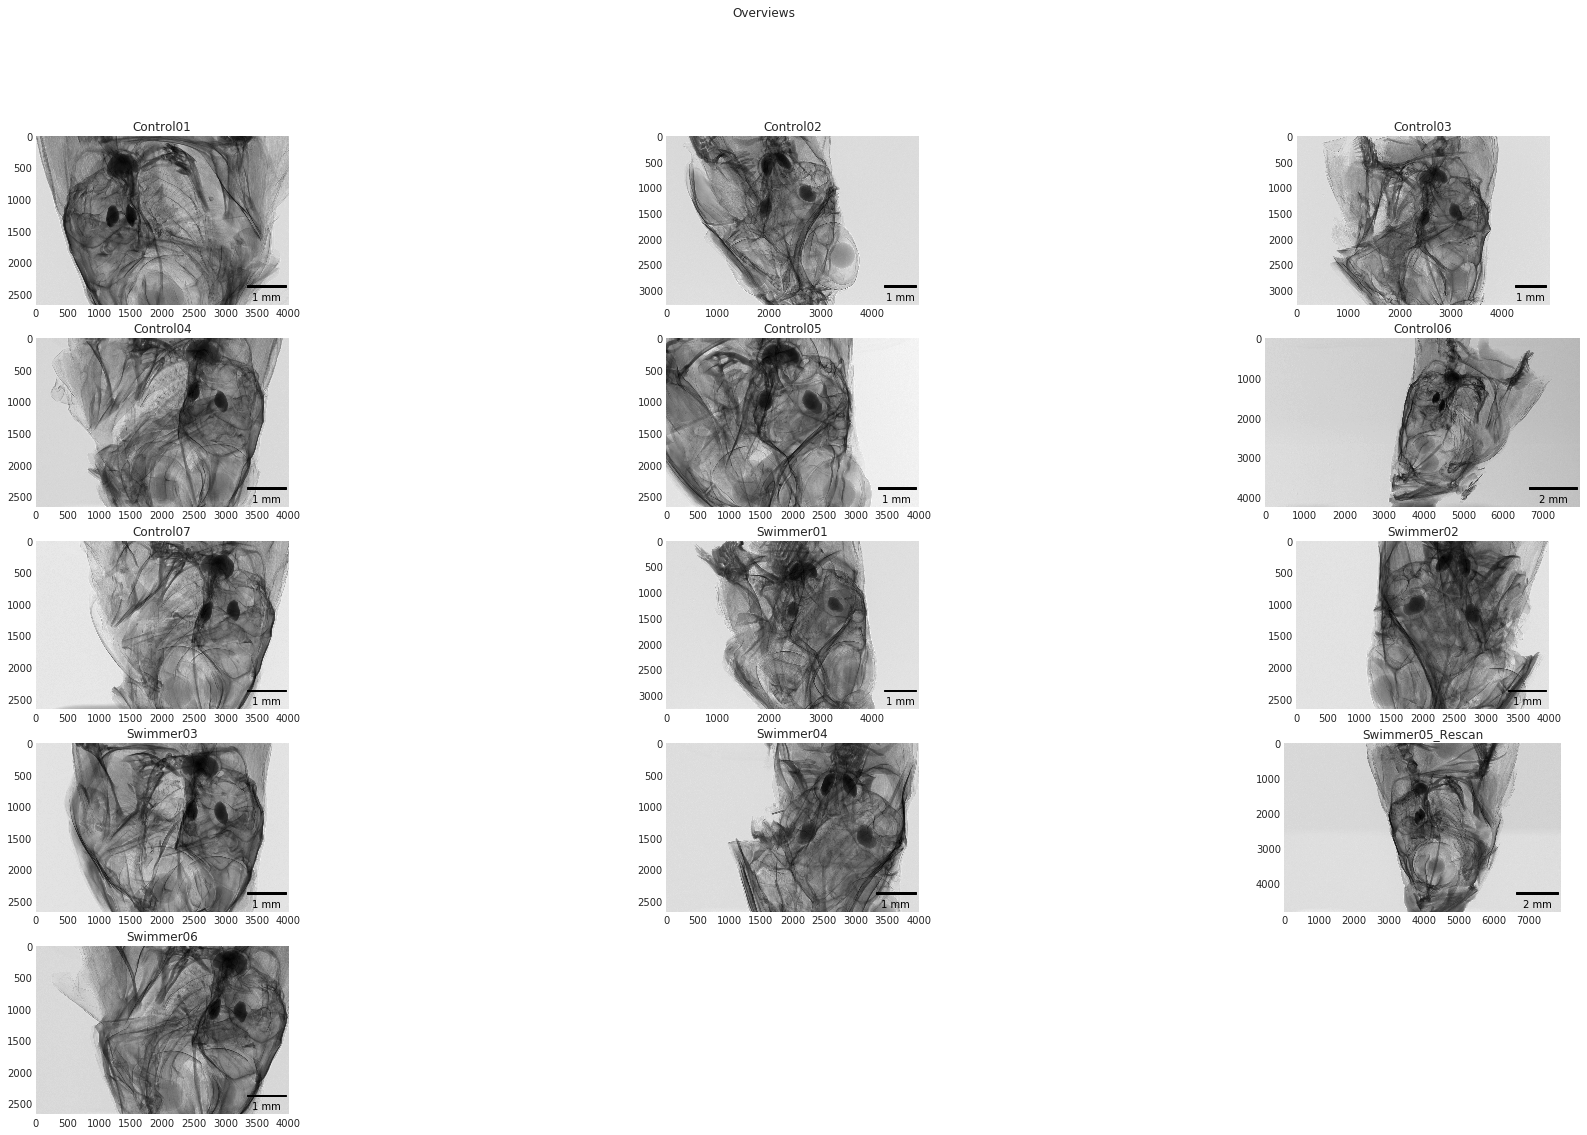

In [19]:
# Diplay overviews (shadow projections)
for c, o in enumerate(Overviews):
    plt.subplot(lines, numpy.ceil(len(Overviews) / float(lines)), c + 1)
    plt.imshow(o)
    plt.gca().add_artist(ScaleBar(PixelSize[c], 'um', color = 'black'))
    plt.axis('off')
    plt.title('%s' % SampleNames[c])
plt.suptitle('Overviews')
plt.savefig(os.path.join(OutPutDir, 'Shadowprojections.png'), bbox_inches='tight')
plt.show()

In [20]:
# Get Middle reconstruction and load it
MiddleSliceName = [r[len(r)//2] for r in VOINames]
MiddleSlice = [scipy.misc.imread(m, flatten=True) for m in MiddleSliceName]

/home/habi/P/Dev/matplotlib-scalebar/matplotlib_scalebar/scalebar.py:449: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(loc):
/home/habi/P/Dev/matplotlib-scalebar/matplotlib_scalebar/scalebar.py:290: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(location):


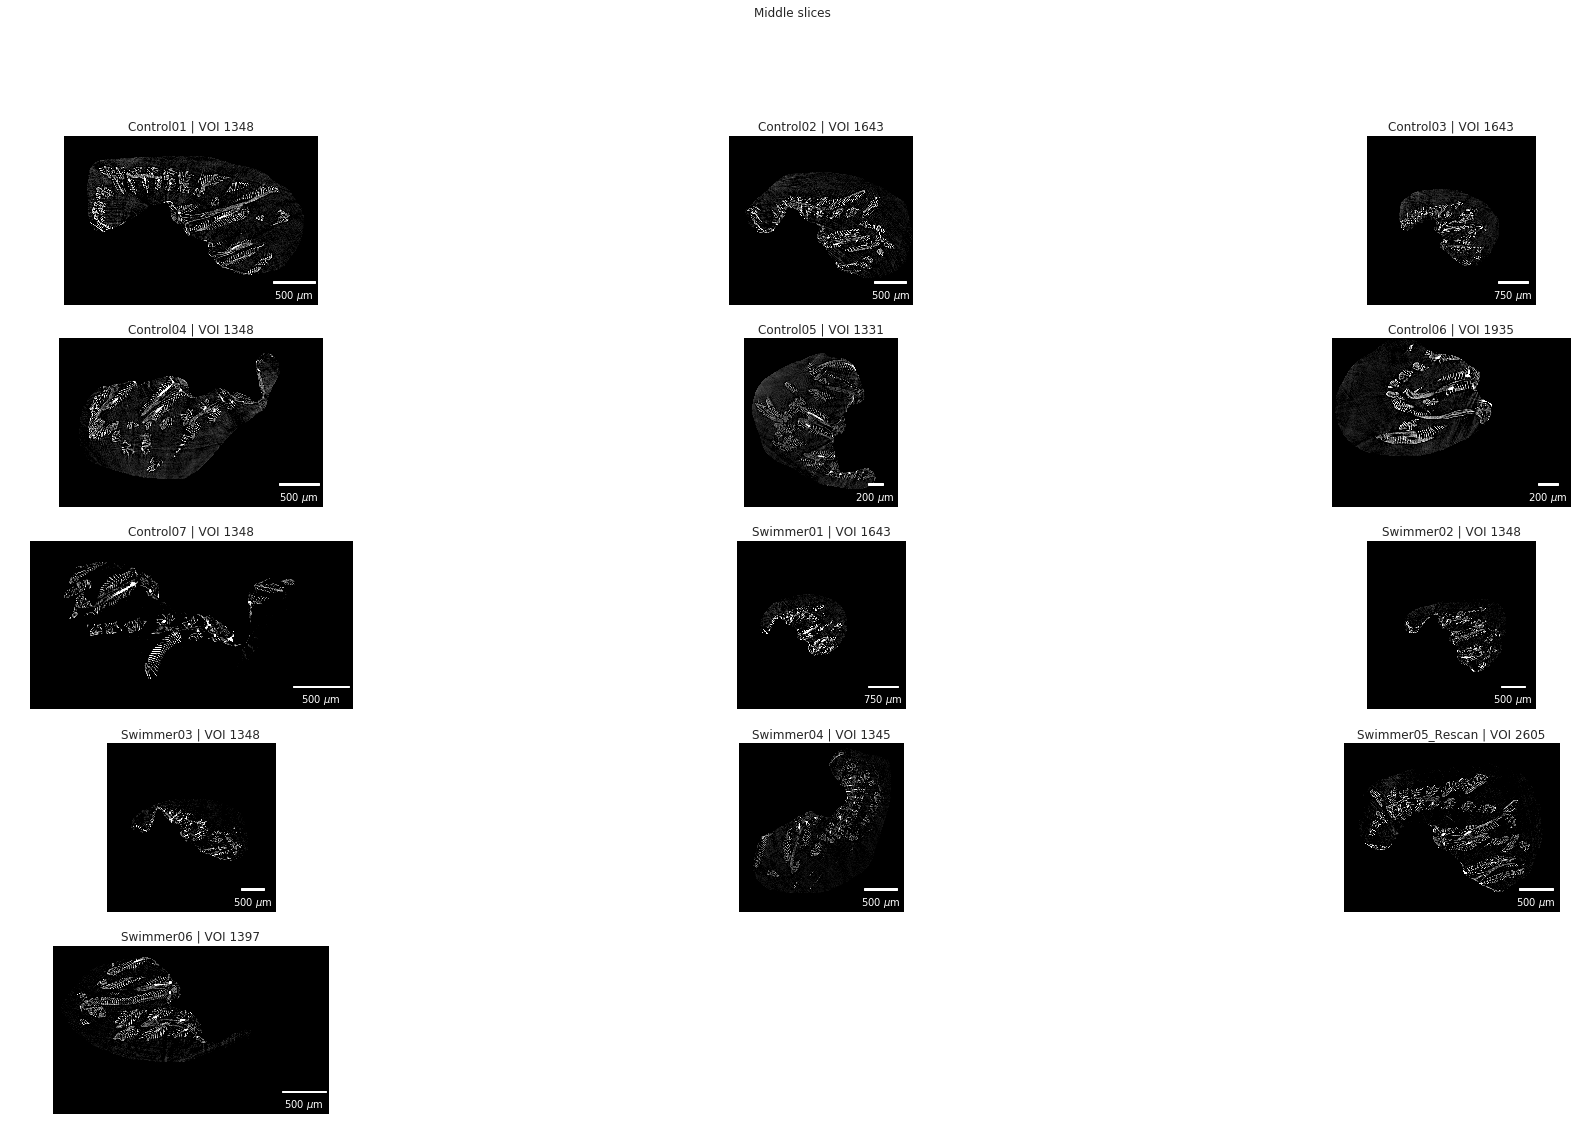

In [21]:
# Display middle slice
for c, m in enumerate(MiddleSlice):
    plt.subplot(lines, numpy.ceil(len(MiddleSlice) / float(lines)), c + 1)
    plt.imshow(m, vmax=0.618 * numpy.max(m))
    plt.title('%s | VOI %s' % (SampleNames[c], os.path.basename(MiddleSliceName[c])[-8:-4]))
    plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))
    plt.axis('off')
plt.suptitle('Middle slices')
plt.savefig(os.path.join(OutPutDir, 'MiddleSlices.png'), bbox_inches='tight')
plt.show()

In [22]:
# Load a random file to get the image size
ImageShape = [numpy.shape(scipy.misc.imread(n[numpy.random.randint(len(n))],
                                            flatten = True)) for n in VOINames]

In [23]:
# Do we have the same ROI for all scans?
if len(numpy.unique(ImageShape)) > 1:
    print('We have %s different ROI sizes!' % len(numpy.unique(ImageShape)))
    print(numpy.unique(ImageShape))
else:
    print('All ROIs are equally sized and square')

We have 21 different ROI sizes!
[ 896 1045 1172 1228 1246 1261 1385 1477 1519 1573 1615 1616 1714 1760 1848
 1913 1936 1943 2184 2240 2524]


In [24]:
# Use a manageable amount of equally spaced slices
HowManySlices = 15
StepWidth = [int(round(len(r) / HowManySlices)) for r in VOINames]
Usethis = [rn[::sw] for rn, sw in zip(VOINames, StepWidth)]
for c, i in enumerate(SampleNames):
    print('For sample %s we are working with a subset of %s (%0.1f %% of totally %s) equally '
          'spaced slices' % (i, len(Usethis[c]), len(Usethis[c]) / len(ReconstructionNames[c]) * 100, 
                             len(ReconstructionNames[c])))

For sample Control01 we are working with a subset of 16 (0.7 % of totally 2452) equally spaced slices
For sample Control02 we are working with a subset of 16 (0.5 % of totally 3062) equally spaced slices
For sample Control03 we are working with a subset of 16 (0.5 % of totally 3062) equally spaced slices
For sample Control04 we are working with a subset of 16 (0.7 % of totally 2452) equally spaced slices
For sample Control05 we are working with a subset of 16 (0.6 % of totally 2642) equally spaced slices
For sample Control06 we are working with a subset of 15 (0.4 % of totally 3389) equally spaced slices
For sample Control07 we are working with a subset of 16 (0.7 % of totally 2452) equally spaced slices
For sample Swimmer01 we are working with a subset of 16 (0.5 % of totally 3062) equally spaced slices
For sample Swimmer02 we are working with a subset of 16 (0.7 % of totally 2452) equally spaced slices
For sample Swimmer03 we are working with a subset of 16 (0.7 % of totally 2452) eq

In [25]:
# Read the images or load the numpy file from disk
FileName = [os.path.join(os.path.dirname(rf), 'voi_from%04dslices.npy' % len(fn)) for rf, fn in zip(VOIFolders, Usethis)]
VOIs = [None] * len(Usethis)
for c, fn in enumerate(FileName):
    if os.path.exists(fn):
        print('%s/%s: Loading %s into memory' % (c+1, len(FileName), fn))
        VOIs[c] = numpy.load(fn, mmap_mode='r')
    else:
        print('%s/%s: Loading %s images from %s' % (c+1, len(FileName), len(Usethis[c]), VOIFolders[c]))
        VOIs[c] = [scipy.misc.imread(img, flatten=True) for img in Usethis[c]]
        numpy.save(fn, VOIs[c], allow_pickle=False)

1/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control01/voi_from0016slices.npy into memory
2/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control02/voi_from0016slices.npy into memory
3/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control03/voi_from0016slices.npy into memory
4/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control04/voi_from0016slices.npy into memory
5/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control05/voi_from0016slices.npy into memory
6/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control06/voi_from0015slices.npy into memory
7/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control07/voi_from0016slices.npy into memory
8/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Swimmer01/voi_from0016slices.npy into memory
9/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Swimmer02/voi_from0016slices.npy into memory
10/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Swim

In [26]:
# Display sampler of slices
# But only if we have less than 11 HowManySlices
ShowHistograms = False
if HowManySlices < 11:
    for c, m in enumerate(SampleNames):
        for d, n in enumerate(Usethis[c]):
            if ShowHistograms:
                plt.subplot(2, len(Usethis[c]), d + 1)
            else:
                plt.subplot(1, len(Usethis[c]), d + 1)
            # Show the selected image
            plt.imshow(numpy.ma.masked_less(VOIs[c][d],25).filled(0))
            # Title depending on which image we show
            if d:
                plt.title('VOI %s' % os.path.splitext(os.path.basename(Usethis[c][d]))[0][-4:])
            else:
                plt.title('Sample %s\nVOI %s' % (SampleNames[c], os.path.splitext(os.path.basename(Usethis[c][d]))[0][-4:]))
                # Scalebar on the first image
                plt.gca().add_artist(ScaleBar(PixelSize[c], 'um', color='white'))                
            if ShowHistograms:
                plt.subplot(2, len(Usethis[c]), d + 1 + len(Usethis[c]))
                plt.hist(VOIs[c][d][VOIs[c][d]>1].ravel(), log=True)
                plt.xlim([0, 255])
            plt.tight_layout
            plt.axis('off')
        plt.savefig(os.path.join(OutPutDir, 'Sampler_%simgs_%s.png' % (len(Usethis[c]), SampleNames[c])), bbox_inches='tight')
        plt.show()
else:
    print('Displaying a sampler with ~%s slices does not make sense...' % HowManySlices)

Displaying a sampler with ~15 slices does not make sense...


In [27]:
# Read or genereate the MIP
FileName = [os.path.join(os.path.dirname(rf), 'mip_from%04dslices.npy' % len(fn)) for rf, fn in zip(RecFolders, Usethis)]
MIPs = [None] * len(Usethis)
for c, fn in enumerate(FileName):
    if os.path.exists(fn):
        print('%s/%s: Loading %s into memory' % (c+1, len(FileName), fn))
        MIPs[c] = numpy.load(fn, mmap_mode='r')
    else:
        print('%s/%s: Generating MIP from %s images' % (c+1, len(FileName), len(Usethis[c])))
        MIPs[c] = numpy.max(VOIs[c], axis=0)
        numpy.save(fn, MIPs[c], allow_pickle=False)
        scipy.misc.imsave(os.path.splitext(fn)[0] + '.png', MIPs[c])        

1/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control01/mip_from0016slices.npy into memory
2/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control02/mip_from0016slices.npy into memory
3/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control03/mip_from0016slices.npy into memory
4/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control04/mip_from0016slices.npy into memory
5/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control05/mip_from0016slices.npy into memory
6/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control06/mip_from0015slices.npy into memory
7/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Control07/mip_from0016slices.npy into memory
8/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Swimmer01/mip_from0016slices.npy into memory
9/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Swimmer02/mip_from0016slices.npy into memory
10/13: Loading /media/habi/Blue Seagate/Zebra-Fish_Matthias/Swim

/home/habi/P/Dev/matplotlib-scalebar/matplotlib_scalebar/scalebar.py:449: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(loc):
/home/habi/P/Dev/matplotlib-scalebar/matplotlib_scalebar/scalebar.py:290: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(location):


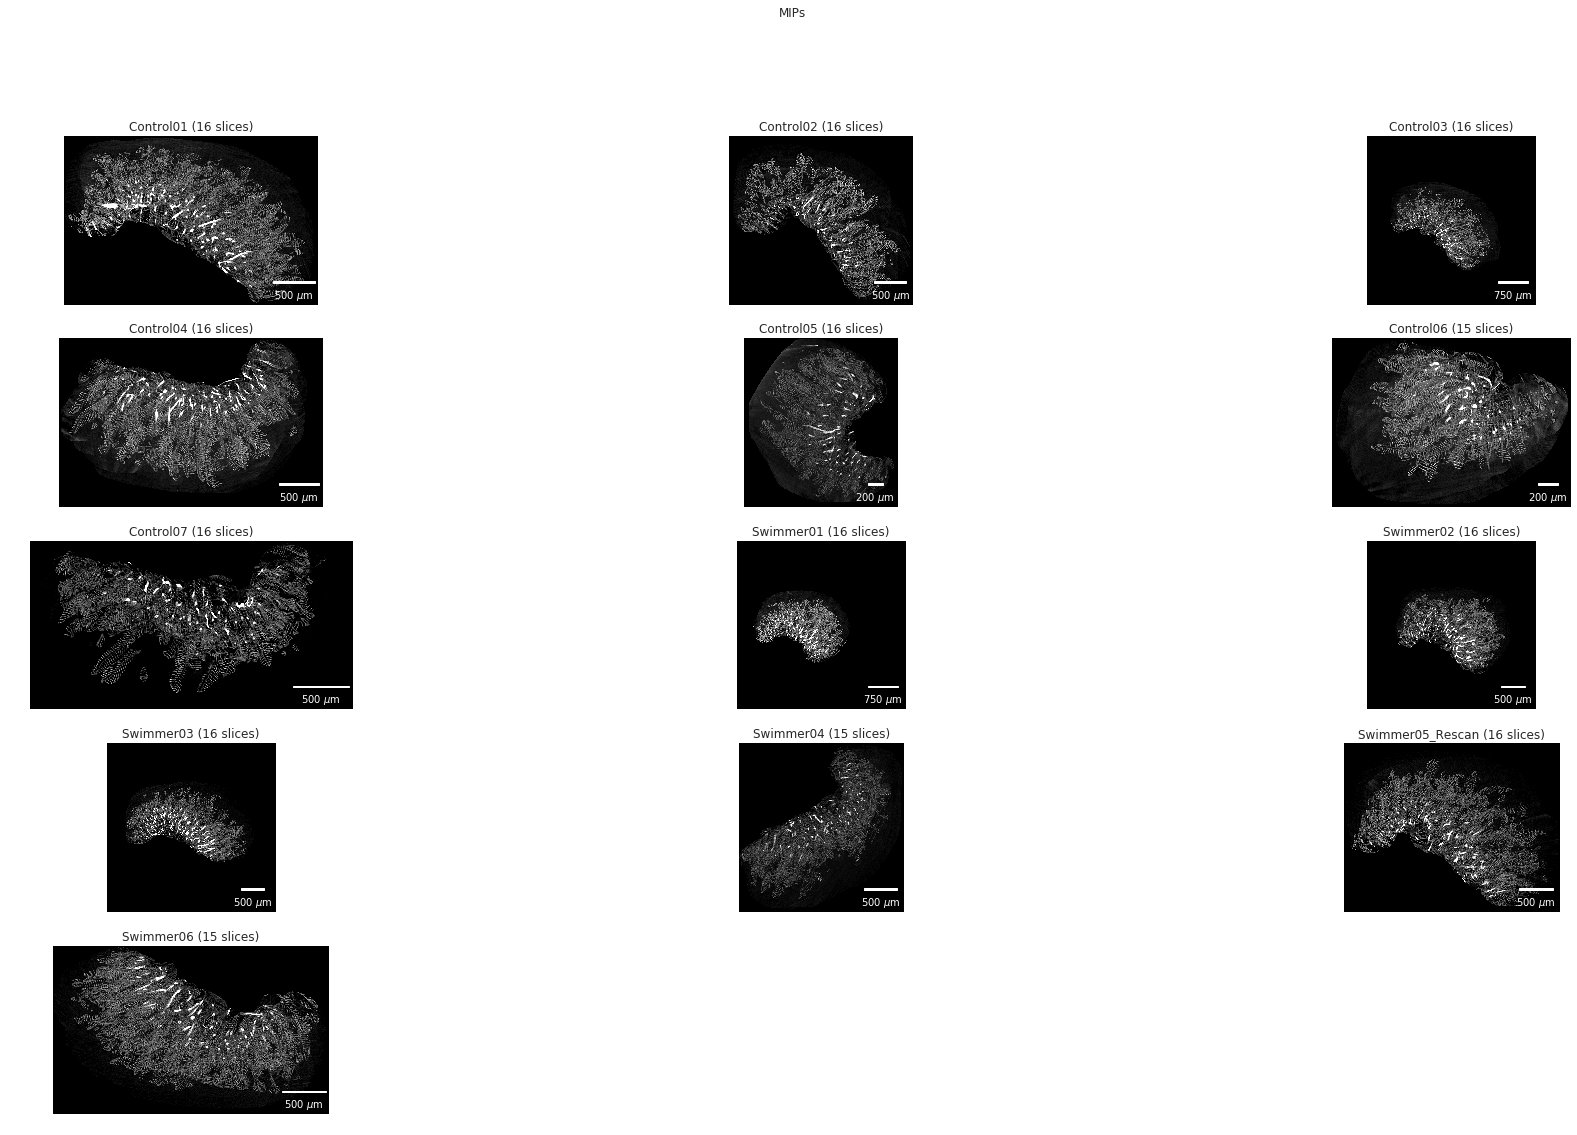

In [28]:
# Display 'through-the-sample' MIPs
for c, m in enumerate(MIPs):
    plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
    plt.imshow(m)
    plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))
    plt.title('%s (%s slices)' % (SampleNames[c],
                                      len(Usethis[c])))
    plt.axis('off')
plt.suptitle('MIPs')
plt.savefig(os.path.join(OutPutDir, 'MIPs_from%04dslices.png' % HowManySlices), bbox_inches='tight')
plt.show()

In [29]:
Otsu_MIP = [skimage.filters.threshold_otsu(image) for image in MIPs]

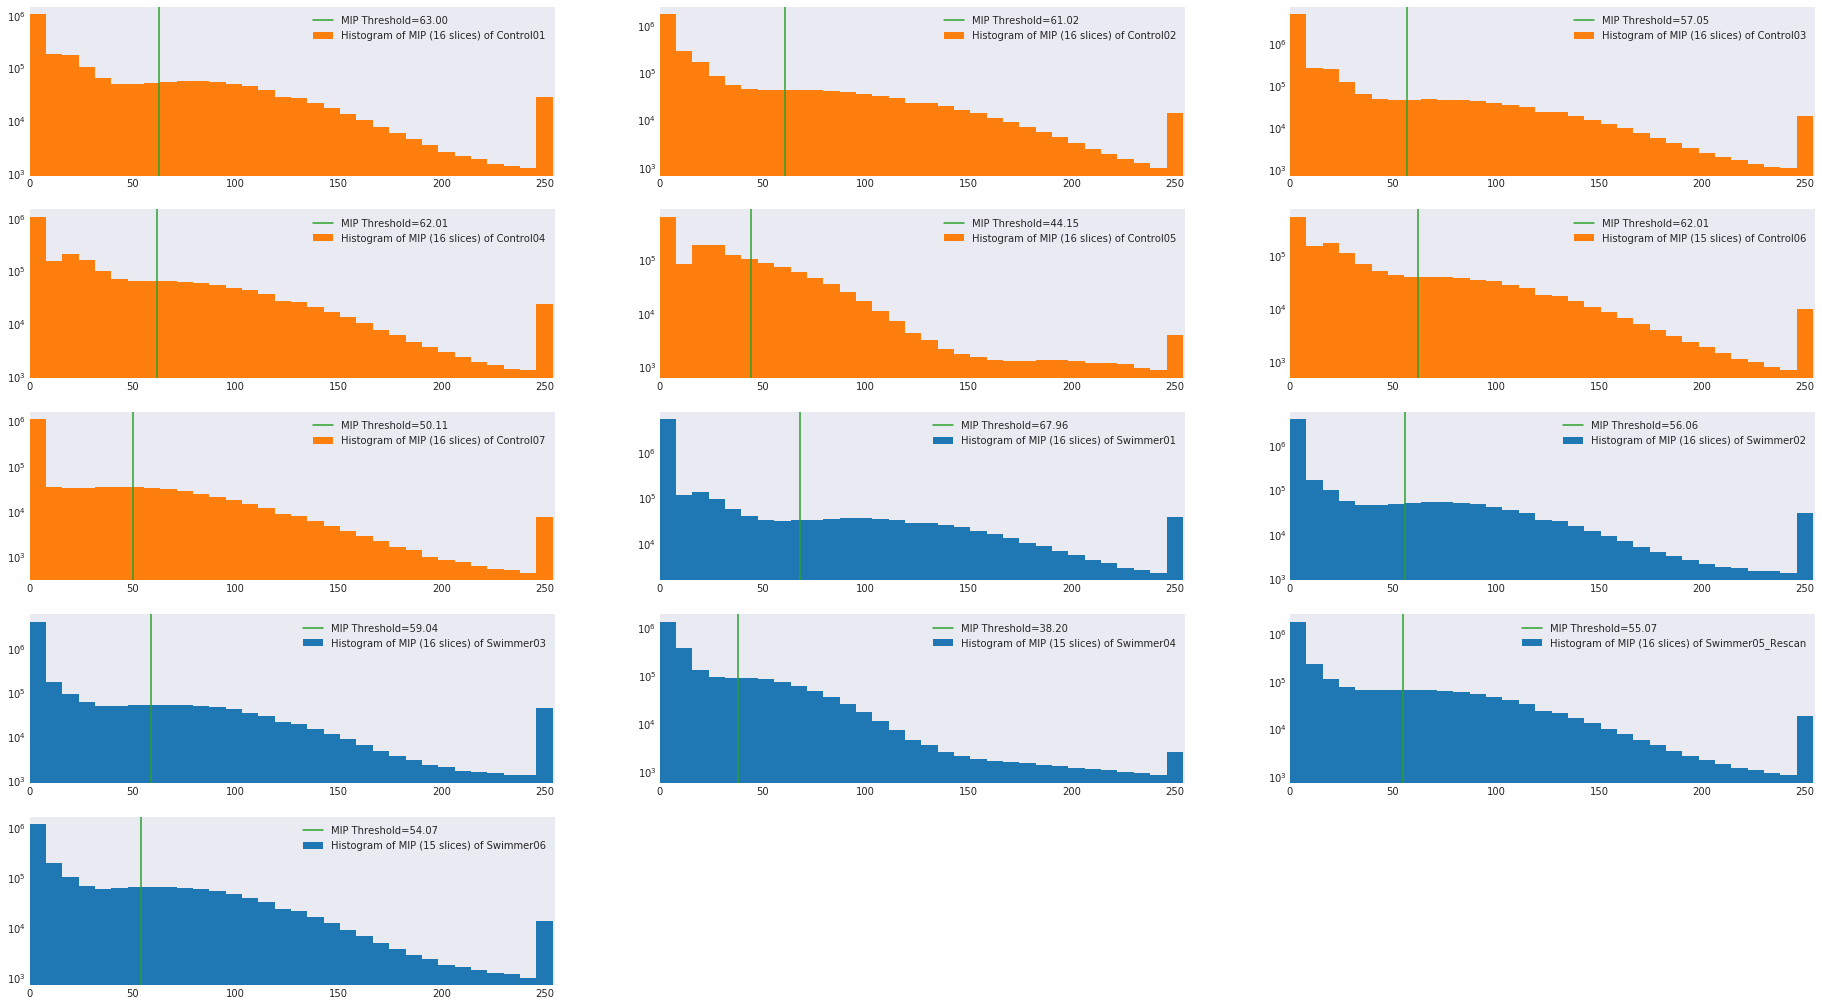

In [30]:
# Display MIP Histograms
for c, m in enumerate(MIPs):
    plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
    plt.hist(m.ravel(), log=True, bins=32, color=experimentcolor[c],
             label='Histogram of MIP (%s slices) of %s' % (len(Usethis[c]), SampleNames[c]))
    plt.axvline(Otsu_MIP[c], c=seaborn.color_palette()[2], label='MIP Threshold=%0.2f' % Otsu_MIP[c])
    plt.xlim([0,255])
    plt.legend()
plt.savefig(os.path.join(OutPutDir, 'MIP_Histograms_from%04dslices.png' % HowManySlices), bbox_inches='tight')
plt.show()

In [31]:
CalculateAllThresholds = False

In [32]:
if CalculateAllThresholds:
    # This will take a long time, since we calculate the threshold for *every* image!
    # If the image is only black (numpy.mean(image)==0), save 'None' as Threshold...
    Otsu = [[skimage.filters.threshold_otsu(image) if numpy.mean(image) else numpy.nan for image in sample] for sample in VOIs]

In [33]:
if CalculateAllThresholds:
    # grab the thresholds in the 60-80% range of the respective values
    split = 5
    Selected = [sorted(t)[(split-2)*len(t)//split:(split-1)*len(t)//split] if t else numpy.nan for t in Otsu]
    # mask the values of the threshold that are *not* in this range
    Otsu_selected = [numpy.ma.masked_outside(o, numpy.min(sel), numpy.max(sel)) for o, sel in zip(Otsu, Selected)]
    # use the mean of this 60-80% value to threshold the datasets
    GlobalThreshold = [numpy.nanmean(os) for os in Otsu_selected]

In [34]:
# FORCE THRESHOLD
# GlobalThreshold = [20 for t in GlobalThreshold]

In [35]:
# Grab the maximal amount of images, for scaling the plots
MaxImages = 0
for i in Usethis:
    MaxImages = max(MaxImages, len(i))

In [36]:
if CalculateAllThresholds:
    for c, s in enumerate(SampleNames):
        plt.plot(Otsu[c], marker='.', label='%s | Global Otsu Mean=%.2f | 60-80%% Otsu mean=%0.2f '
                 '| MIP Otsu=%0.2f' % (s,
                                       numpy.nanmean(Otsu[c]),
                                       GlobalThreshold[c],
                                       Otsu_MIP[c]),
                 c=seaborn.color_palette(n_colors=len(SampleNames))[c])
        plt.plot(Otsu_selected[c], '.', ms=20, alpha=0.618, markeredgecolor='k', markeredgewidth=1, 
                 c=seaborn.color_palette(n_colors=len(SampleNames))[c])
        plt.axhline(Otsu_MIP[c], alpha=0.618, c=seaborn.color_palette(n_colors=len(SampleNames))[c])
        plt.legend(loc='best')
    plt.xlim([0, MaxImages - 1])
    plt.title('Otsu thresholds for each slice of each sample')
    plt.savefig(os.path.join(OutPutDir, 'Thresholds.png'), bbox_inches='tight')
    plt.show()

In [37]:
if CalculateAllThresholds:
    GlobalOtsu = [skimage.filters.threshold_otsu(numpy.array(r)) if r else numpy.nan for r in VOIs]

In [38]:
if CalculateAllThresholds:
    # Compare global Otsu threshold, 60%-80% selected threshold and threshold from MIPs
    for c,s in enumerate(SampleNames):
        print('For %s we have a' % s)
        print('\t- 60-80%% selected threshold of %0.2f' % GlobalThreshold[c])
        print('\t- global Otsu threshold of %0.2f' % GlobalOtsu[c])
        print('\t- Otsu threshold calculated from the MIP of %0.2f' % Otsu_MIP[c])

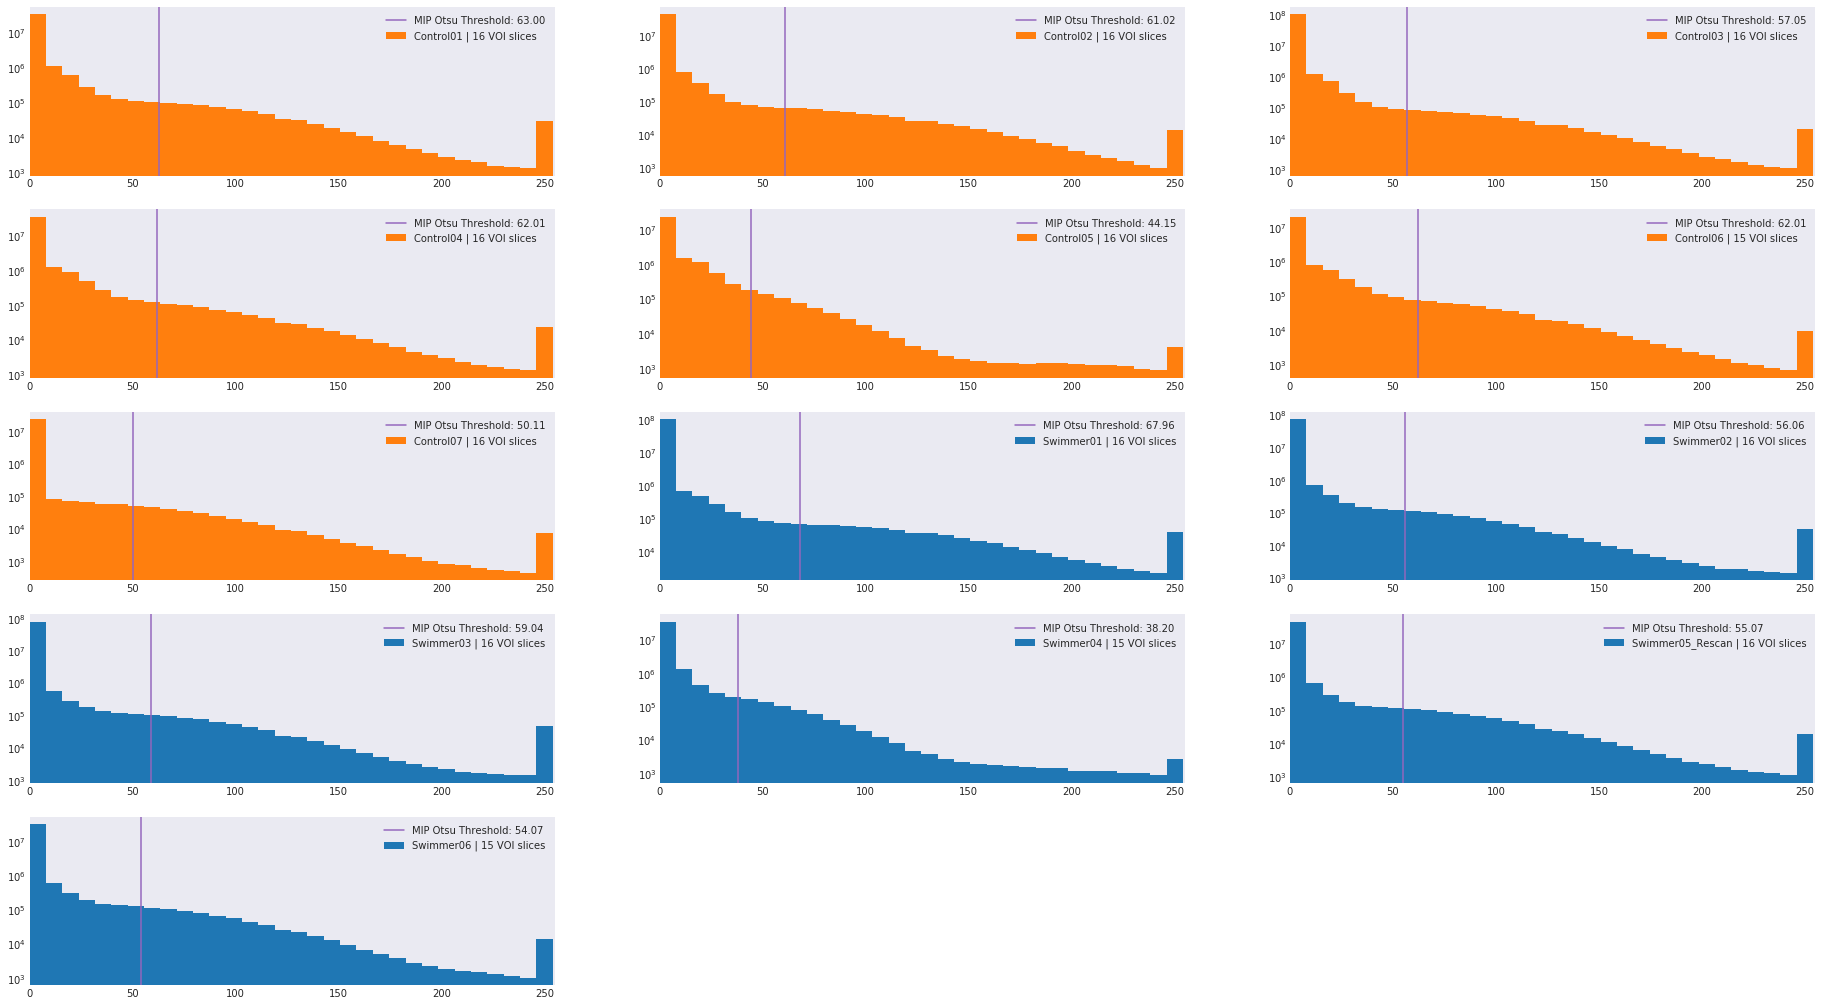

In [39]:
# Show all (global) histograms
for c, s in enumerate(SampleNames):
    plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
    plt.hist(numpy.array(VOIs[c]).ravel(), bins=32, log=True, color=experimentcolor[c], 
             label='%s | %s VOI slices' % (s, len(VOIs[c])))
    if CalculateAllThresholds:
        plt.axvline(GlobalThreshold[c],
                    label='Selected Threshold: %0.2f' % GlobalThreshold[c],
                    c=seaborn.color_palette()[2])
        plt.axvline(GlobalOtsu[c], label='Mean Otsu Threshold: %0.2f' % GlobalOtsu[c],
                    c=seaborn.color_palette()[3])
    plt.axvline(Otsu_MIP[c], label='MIP Otsu Threshold: %0.2f' % Otsu_MIP[c],
                c=seaborn.color_palette()[4])
    plt.legend()
    plt.xlim([0, 255])
plt.savefig(os.path.join(OutPutDir, 'Histograms_Thresholds_from%04dslices.png' % HowManySlices), bbox_inches='tight')
plt.show()

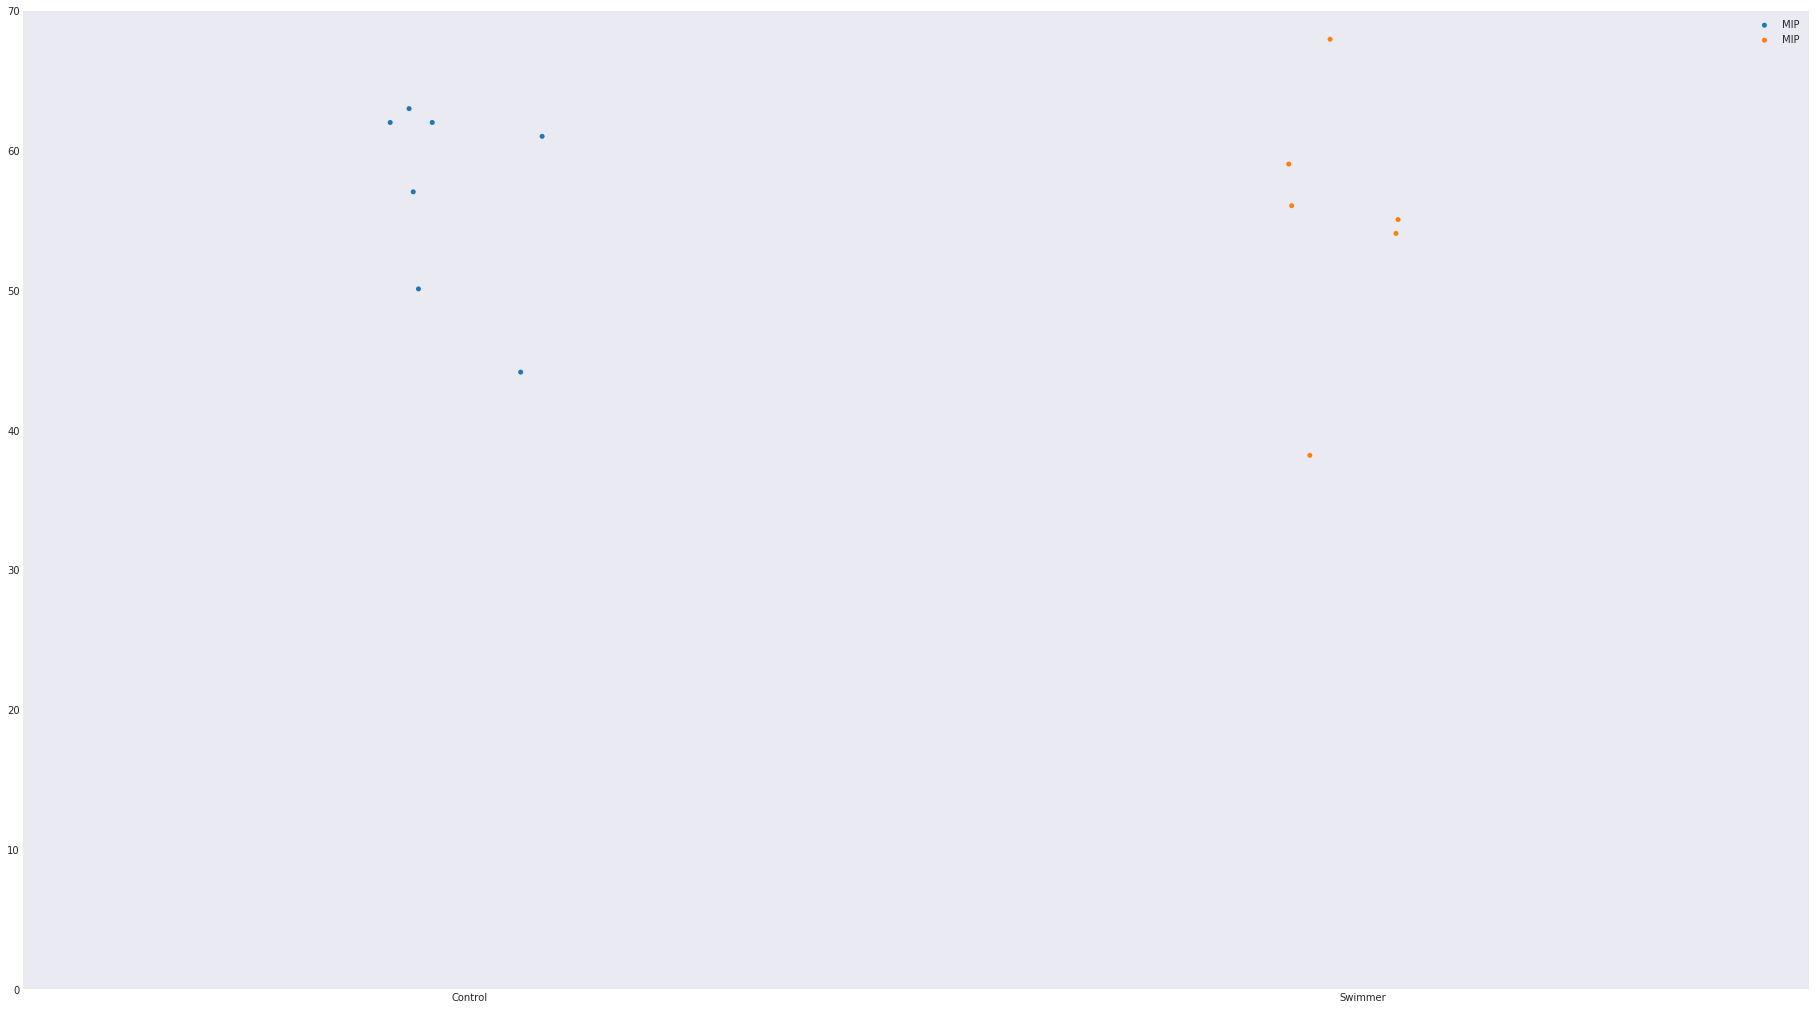

In [40]:
if CalculateAllThresholds:
    plt.subplot(131)
seaborn.stripplot(x=Experiment, y=Otsu_MIP, jitter=True, label='MIP')
plt.legend()
plt.ylim([0,70])
if CalculateAllThresholds:
    plt.subplot(132)
    seaborn.stripplot(x=Experiment, y=GlobalOtsu, jitter=True, label='GobalOtsu')
    plt.legend()
    plt.ylim([0,70])
    plt.subplot(133)
    seaborn.stripplot(x=Experiment, y=GlobalThreshold, jitter=True, label='GlobalThreshold')
    plt.legend()
    plt.ylim([0,70])
plt.show()

/home/habi/P/Dev/matplotlib-scalebar/matplotlib_scalebar/scalebar.py:449: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(loc):
/home/habi/P/Dev/matplotlib-scalebar/matplotlib_scalebar/scalebar.py:290: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(location):


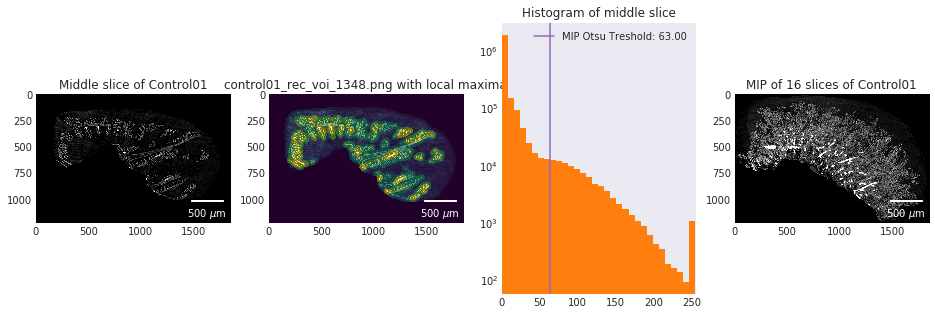

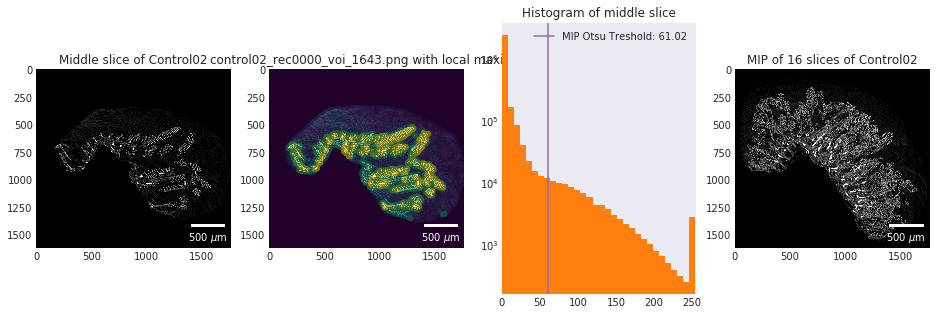

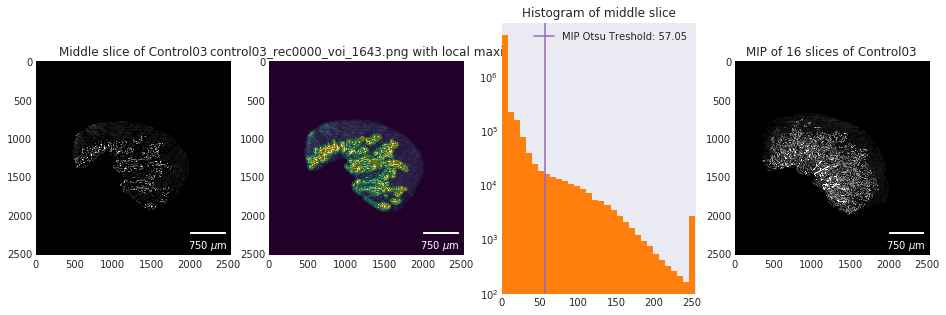

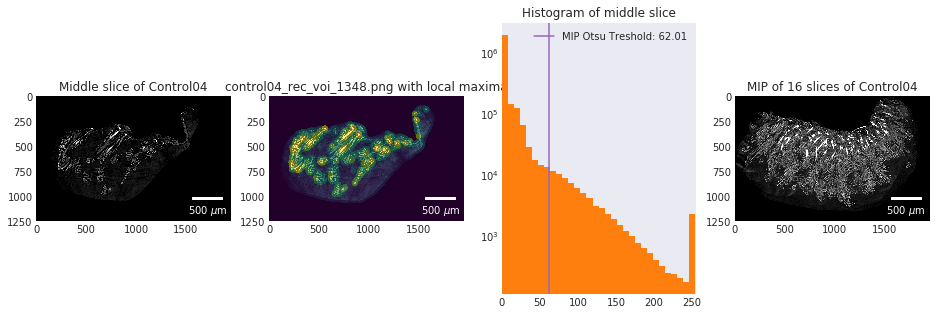

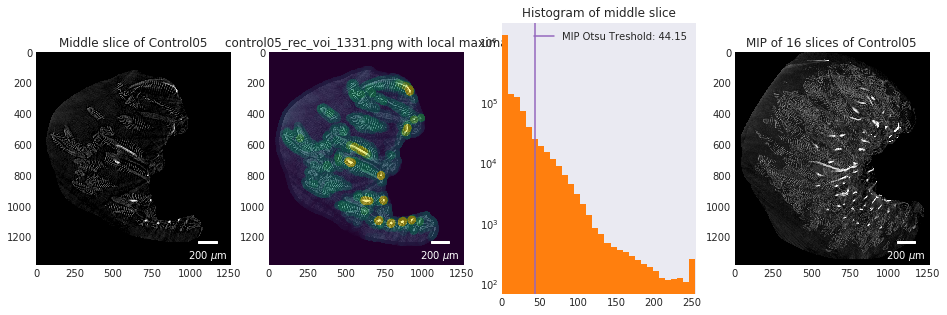

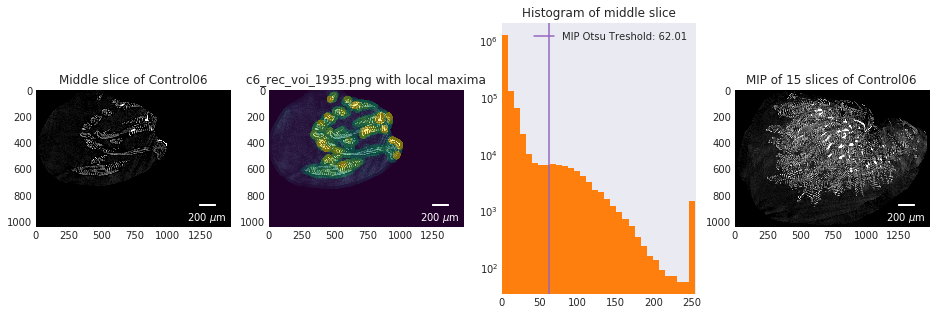

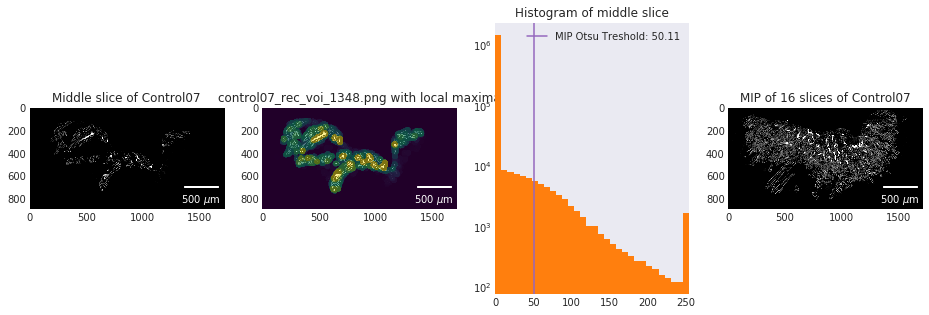

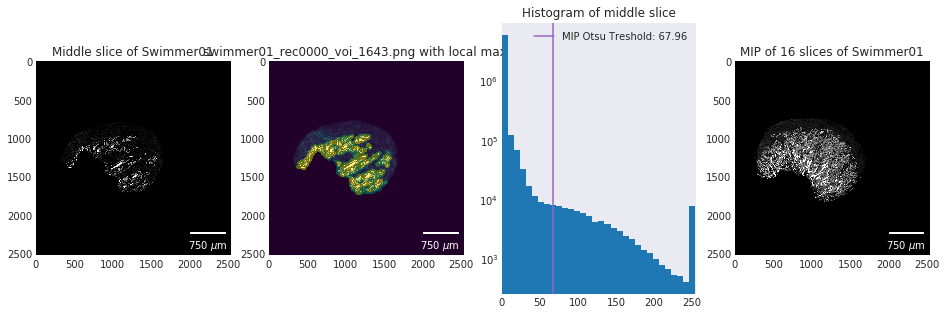

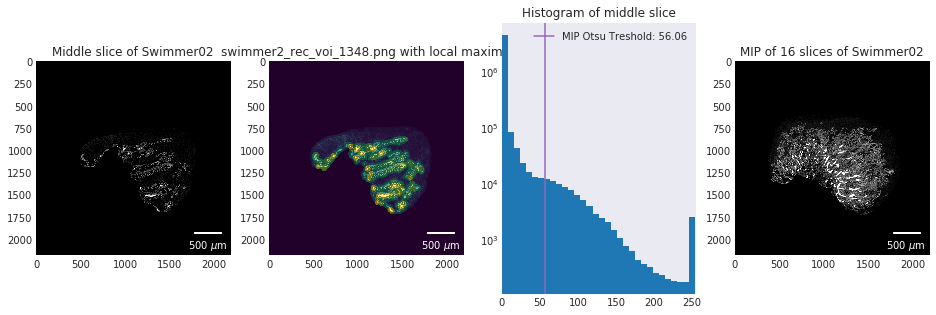

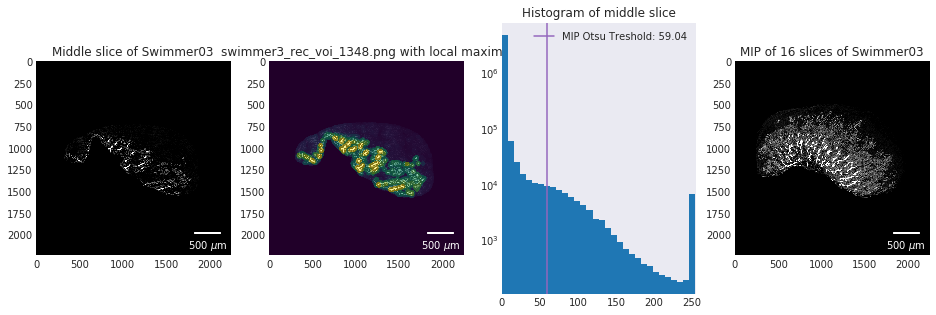

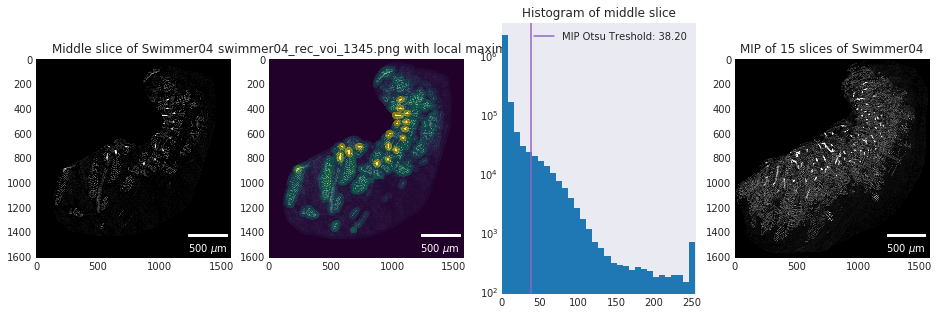

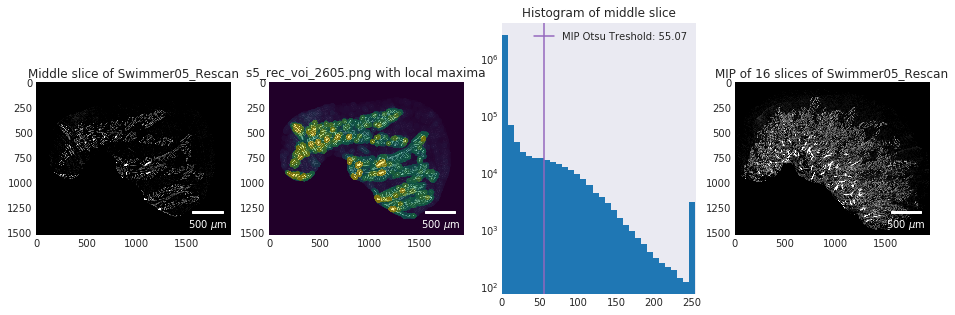

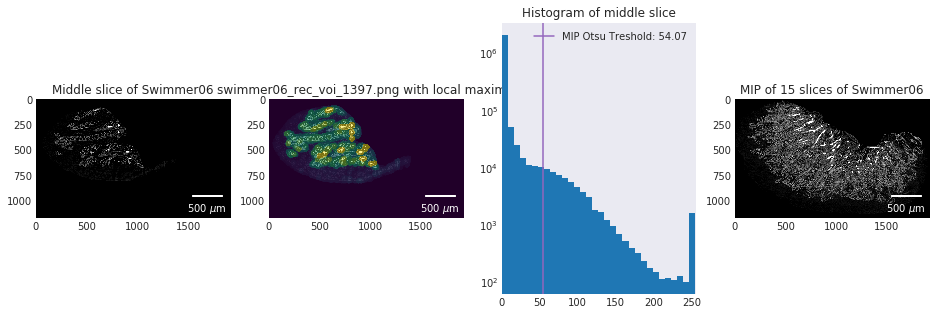

In [41]:
# Show middle images with some data
plt.rcParams['figure.figsize'] = (16, 5)
for c,s in enumerate(SampleNames):
    maximum = skimage.filters.rank.maximum(MiddleSlice[c].astype('uint8'), skimage.morphology.disk(25))
    plt.subplot(141)
    plt.imshow(MiddleSlice[c])
    plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))
    plt.title('Middle slice of %s' % s)
    plt.subplot(142)
    plt.imshow(MiddleSlice[c], vmax=0.618*numpy.max(MiddleSlice[c]))
    plt.imshow(maximum, cmap='viridis', alpha=0.5)
    plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))    
    plt.title('%s with local maxima' % os.path.basename(MiddleSliceName[c]))
    plt.subplot(143)
    plt.hist(MiddleSlice[c].ravel(), bins=32, log=True, color=experimentcolor[c])
    if CalculateAllThresholds:
        plt.axvline(GlobalThreshold[c], c=seaborn.color_palette()[1], label='Global Treshold@%0.2f' % GlobalThreshold[c])
        plt.axvline(GlobalThreshold[c],
                    label='Selected Threshold: %0.2f' % GlobalThreshold[c],
                    c=seaborn.color_palette()[2])
        plt.axvline(GlobalOtsu[c], label='Global Otsu Threshold: %0.2f' % GlobalOtsu[c],
                    c=seaborn.color_palette()[3])        
    plt.axvline(Otsu_MIP[c], c=seaborn.color_palette()[4], label='MIP Otsu Treshold: %0.2f' % Otsu_MIP[c])        
    plt.legend(loc='best')
    plt.xlim([0,255])
    plt.title('Histogram of middle slice')
    plt.subplot(144)
    plt.imshow(MIPs[c])
    plt.title('MIP of %s slices of %s' % (len(Usethis[c]),
                                          SampleNames[c]))
    plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))
    plt.savefig(os.path.join(OutPutDir, 'Details_%s.png' % SampleNames[c]), bbox_inches='tight')
    plt.show()
plt.rcParams['figure.figsize'] = (16, 9)

In [42]:
import skimage.morphology
def gills_per_area(image, threshold=None, verbose=False):
    # mask out Deas ROI
    masked = numpy.ma.masked_equal(image,0)
    if not threshold:
        # Calculate the Otsu threshold of the image if needed
        threshold = skimage.filters.threshold_otsu(image)        
    thresholded_image = image > threshold
    binary_closing = True
    if binary_closing:
        # Use simple binary closing
        closed  = skimage.morphology.binary_closing(thresholded_image, selem=skimage.morphology.selem.disk(25))
    else:
        # Close small holes (this should be a bit more robust than simple binary closing)
        imagearea = numpy.shape(image)[0] * numpy.shape(image)[1] 
        closed  = skimage.morphology.remove_small_holes(thresholded_image, area_threshold=imagearea*.618)
    if verbose:
        plt.subplot(131)
        plt.imshow(masked.filled(0))
        plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))
        plt.axis('off')
        plt.title('Original')
        plt.subplot(132)
        plt.imshow(thresholded_image)
        plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))
        plt.axis('off')
        plt.title('Thresholded with %0.2f: %0.2g px' % (threshold, numpy.sum(thresholded_image)))
        plt.subplot(133)
        plt.imshow(closed)
        plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))        
        plt.axis('off')
        plt.title('Closed: %0.2g px' % numpy.sum(closed))
        plt.show()
    gpa = numpy.divide(numpy.sum(thresholded_image), numpy.sum(closed))
    return(gpa)

In [43]:
Area = [gills_per_area(m, verbose=False, threshold=t) for m,t in zip(MiddleSlice, Otsu_MIP)]

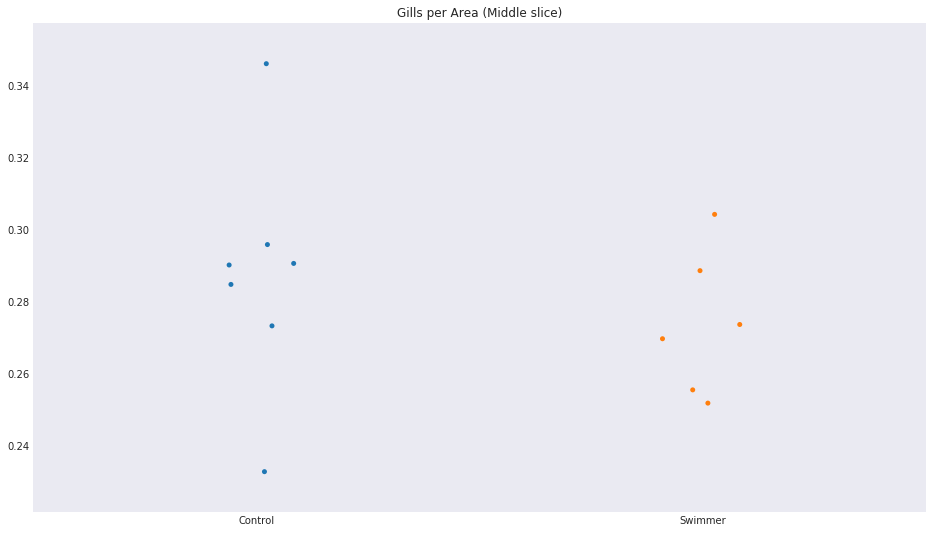

In [44]:
seaborn.stripplot(x=Experiment, y=Area, jitter=True)
plt.title('Gills per Area (Middle slice)')
plt.savefig(os.path.join(OutPutDir, 'GillsArea_per_ArchArea.png'), bbox_inches='tight')
plt.show()